<a href="https://colab.research.google.com/github/twloehfelm/AI-Deep-Learning-Lab-2023/blob/twl-nb-v1.0/sessions/dicom-seg/RSNA_2023_DICOM_IN_DICOM_OUT_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table width="100%">
    <tr>
      <td align="center"><h1>DICOM IN, DICOM OUT Segmentation</h1></td>
    </tr>
    <tr>
      <td align="center"><h2> 🔥 Now with 💯 TotalSegmentator❗ 🔥 </h1></td>
</table>


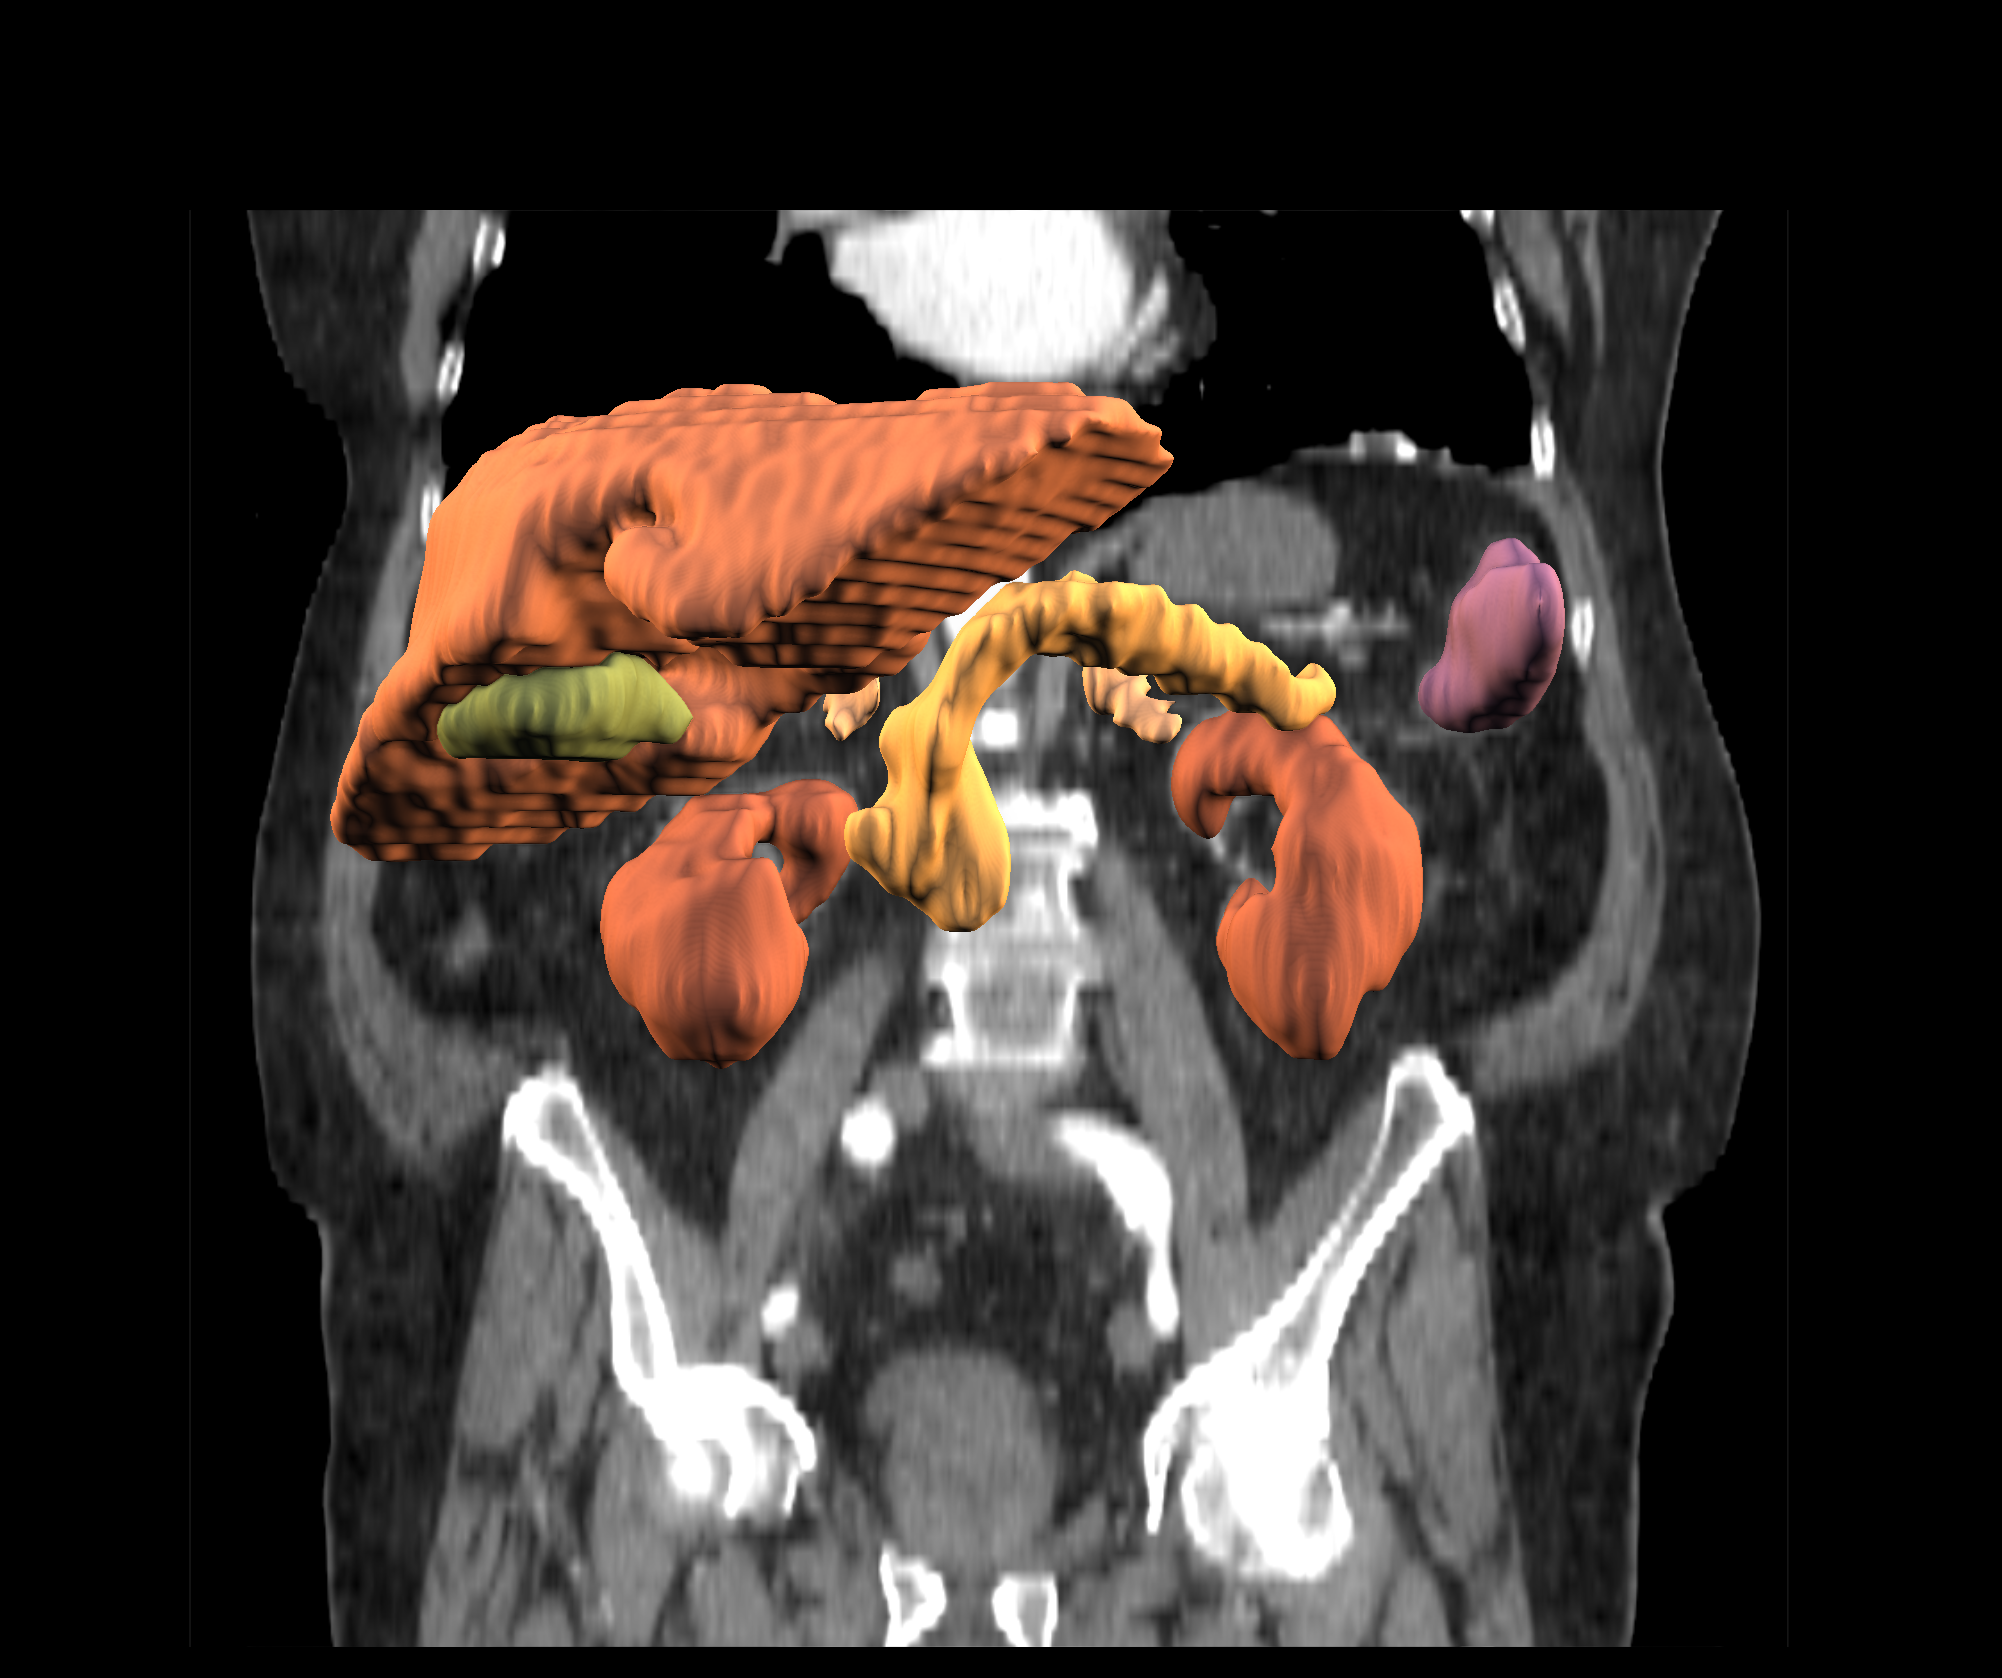

In previous years we modified Facebook's detectron2 segmentation tool to use native `DICOM` and `DICOM SEG` for the segmentation masks. This allowed us to train and deploy a segmentation tool that accepted native `DICOM` and returned `DICOM SEG`, which was pretty neat.

That version of the tutorial is available in the RSNA 2022 public Github repo - please check it out for tips on how to modify detectron2 to read DICOM and output DICOM SEG.

---
That strategy was recently rendered mostly obsolete by the release of [TotalSegmentator](https://pubs.rsna.org/doi/full/10.1148/ryai.230024) (Wasserthal et al.), an ***incredible*** tool that works off-the-shelf to segment all of the major organs on CT. It accepts `DICOM` or `nifti`, so satisfies our `DICOM IN...` requirement, but it can't output `DICOM SEG`, instead producing either `nifti` or the much less useful `DICOM RT STRUCT` - this is a minor deficiency of an otherwise incredible tool. Here we'll learn how to convert the output of TotalSegmentator to `DICOM SEG`.

---
Keeping the entire pipeline in `DICOM` offers signfiicant advantages for workflow and visualization. The link between the segmentation files and the source images is maintained by a robust header, which also facilitates proper indexing and retrieval of data from DICOM archives. And, `DICOM` files can be easily sent from and returned to most modern clinical PACS, enabling segmentation pipelines to be inserted into routine clinical and research data flows. Open-source DICOM tools like the [OHIF Viewer](https://ohif.org/) and [3D Slicer](https://www.slicer.org/) can easily display and transact `DICOM` and `DICOM SEG` too.

---

By the end of this session, we'll have the framework for a simple tool that takes `DICOM` CTs in one end, performs 3D segmentation of >100 structures throughout the body, and returns `DICOM SEG`.

---

This notebook is intended as an introduction to working with DICOM SEG and is not intended
to provide best practices coding advice. As you gain some experience please consider exploring other tools with more robust community support such as [3D Slicer](https://www.slicer.org/) or [dcmqi](https://qiicr.gitbook.io/dcmqi-guide/).

---
This notebook is indebted to the developers of pydicom, [highdicom](https://highdicom.readthedocs.io/en/latest/), and, most of all, the generous geniuses behind [TotalSegmentator](https://github.com/wasserth/TotalSegmentator).

# Install required packages and helper functions

In [ ]:
%reload_ext autoreload
%autoreload

In [ ]:
# Install a few python libraries to facilitate working with DICOM (pydicom) and DICOM SEG (highdicom), and the totalsegmentator tool
!pip3 install -q pydicom highdicom totalsegmentator colorspacious > /dev/null

In [ ]:
# import some common libraries
import numpy as np
import pandas as pd
from pathlib import Path
import shutil
from colorspacious import cspace_convert

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.pyplot import imshow
from matplotlib.colors import ListedColormap

import plotly.graph_objects as go

import pydicom
from pydicom import dcmread
from pydicom.sr.codedict import codes
from pydicom.uid import generate_uid

import highdicom
from highdicom.content import AlgorithmIdentificationSequence
from highdicom.seg.content import SegmentDescription
from highdicom.content import PixelMeasuresSequence
from highdicom.seg.enum import (
  SegmentAlgorithmTypeValues,
  SegmentationTypeValues
)
from highdicom.seg.sop import Segmentation
from highdicom.sr import CodedConcept

from totalsegmentator.python_api import totalsegmentator

import nibabel as nib

In [ ]:
# Download sample data to root directory
!wget -q -O /content/rsna2023.zip https://www.dropbox.com/scl/fi/qo9exh6vk17smaq3uv3vn/rsna2023.zip?rlkey=b053r4hehcfazstuzwighk9p5&dl=0
!unzip /content/rsna2023.zip -d /content > /dev/null

# Clean up data folders
!rm -rf ./rsna2023.zip
!rm -rf ./sample_data
!rm -rf ./__MACOSX
ROOT_PATH = Path('/content/rsna2023')
[f.unlink() for f in sorted(ROOT_PATH.glob("**/.DS_Store"))]
sample_pt = next((ROOT_PATH/'sample_pt').iterdir())

In [ ]:
# Retrieve a mapping table to translate totalsegmentator labels to SNOMED codes for proper DICOM SEG data encoding
totalseg_to_snomed_df = pd.read_csv('https://raw.githubusercontent.com/wasserth/TotalSegmentator/master/resources/totalsegmentator_snomed_mapping.csv')
totalseg_to_snomed_df.set_index('Structure', inplace=True)
totalseg_to_snomed_dict = totalseg_to_snomed_df.to_dict(orient='index')

In [ ]:
# Helper functions
def coded_concepts_from_totalseg_label(totalseg_label, totalseg_to_snomed_dict):
  data = totalseg_to_snomed_dict.get(totalseg_label, None)
  if data:
    category_code = CodedConcept(
      str(data['SegmentedPropertyCategoryCodeSequence.CodeValue']),
      data['SegmentedPropertyCategoryCodeSequence.CodingSchemeDesignator'],
      data['SegmentedPropertyCategoryCodeSequence.CodeMeaning'],
      None
    )
    type_code = CodedConcept(
      str(data['SegmentedPropertyTypeCodeSequence.CodeValue']),
      data['SegmentedPropertyTypeCodeSequence.CodingSchemeDesignator'],
      data['SegmentedPropertyTypeCodeSequence.CodeMeaning'],
      None
    )
  else:
    category_code = None
    type_code = None
  return category_code, type_code


# from fastai2 medical imaging
def windowed(px, w, l):
    """Windows a pixel_array of Houndfield units. N.B. This is only used when we are displaying the image for visual effects.
    DO NOT window the HU pixel_array when training, since windowing truncates the dynamic range of the image and causes information loss.
    args:
      px = pixel array in Houndfield units
      w = window width (HU range)
      l = window level (center point)
    returns:
      pixel_array convered to the given window/level
    """
    if type(w) == pydicom.multival.MultiValue:
      w = w[0]
    if type(l) == pydicom.multival.MultiValue:
      l = l[0]
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

def get_windowed_image(ds):
  """Helper function that takes a pydicom dataset and returns an image pixel array using the default Window settings specified in the DICOM header"""
  im = ds.pixel_array
  im = im*ds.RescaleSlope + ds.RescaleIntercept
  im = windowed(im, ds.WindowWidth, ds.WindowCenter)
  return im

def show_img_array(images, columns=10, title=None):
  ncol = columns
  nrow = len(images) / ncol
  plt.figure(figsize=[ncol*3,1+(nrow*3)], dpi=300)

  gs = gridspec.GridSpec(nrow, ncol, width_ratios=np.ones(ncol),
         wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845)

  plt.suptitle(title)

  for i, image in enumerate(images):
    ax = plt.subplot(len(images) / ncol + 1, ncol, i + 1)
    ax.imshow(image, cmap="gray")
    ax.set_xticklabels([])
    ax.set_yticklabels([])

  plt.axis('off')

  plt.show()

def srgb_to_DICOMLab(rgb):
    l,a,b = cspace_convert(rgb, "sRGB255", "CIELab")
    return list(highdicom.color.CIELabColor(l,a,b).value)

# RGB colors from SlicerTotalSegmentator and GenericAnatomyColors
anatomy_colors = {
    "abdomen": [177,122,101],
    "abdominal cavity": [186,124,161],
    "adenohypophysis": [60,143,83],
    "adrenal_gland_left": [249,186,150],
    "adrenal_gland_right": [249,186,150],
    "anus": [255,224,199],
    "aorta": [224,97,76],
    "aortic valve": [218,123,97],
    "arachnoid": [255,244,209],
    "artery": [216,101,79],
    "atrial septum": [233,138,112],
    "atrial_appendage_left": [233,138,112],
    "autochthon_left": [188,95,76],
    "autochthon_right": [188,95,76],
    "autonomic nerve": [255,226,77],
    "bile": [0,145,30],
    "biliary tree": [0,145,30],
    "bleeding": [188,65,28],
    "blood": [216,101,79],
    "bone": [241,214,145],
    "brachiocephalic_trunk": [216,101,79],
    "brachiocephalic_vein_left": [0,151,206],
    "brachiocephalic_vein_right": [0,151,206],
    "brain": [250,250,225],
    "bronchi": [175,216,244],
    "capillary": [183,156,220],
    "cartilage": [111,184,210],
    "central nervous system": [244,214,49],
    "cerebellar white matter": [194,195,164],
    "cerebral aqueduct": [88,106,215],
    "cerebral cortex": [128,174,128],
    "cerebral white matter": [250,250,225],
    "cerebro-spinal fluid": [85,188,255],
    "cervical vertebral column": [255,255,207],
    "circulatory system": [213,99,79],
    "clavicula_left": [205,179,108],
    "clavicula_right": [205,179,108],
    "clot": [145,60,66],
    "colon": [204,168,143],
    "commissural fibers": [138,95,74],
    "common_carotid_artery_left": [216,101,79],
    "common_carotid_artery_right": [216,101,79],
    "connective tissue": [111,184,210],
    "corpus callosum": [97,113,158],
    "costal_cartilages": [111,184,210],
    "cranial nerves": [255,234,92],
    "CSF space": [85,188,255],
    "cyst": [205,205,100],
    "diencephalon": [69,110,53],
    "duodenum": [255,253,229],
    "dura mater": [255,244,209],
    "edema": [140,224,228],
    "embolism": [150,98,83],
    "endocrine system of brain": [82,174,128],
    "esophagus": [211,171,143],
    "fat": [230,220,70],
    "feces": [78,63,0],
    "female external genitalia": [185,135,134],
    "female internal genitalia": [244,170,147],
    "femur_left": [241,214,145],
    "femur_right": [241,214,145],
    "fluid": [170,250,250],
    "foreign object": [220,245,20],
    "fourth ventricle": [88,106,215],
    "gallbladder": [139,150,98],
    "gas": [218,255,255],
    "gluteus_maximus_left": [192,104,88],
    "gluteus_maximus_right": [192,104,88],
    "gluteus_medius_left": [192,104,88],
    "gluteus_medius_right": [192,104,88],
    "gluteus_minimus_left": [192,104,88],
    "gluteus_minimus_right": [192,104,88],
    "gray matter": [200,200,235],
    "gray matter of brain": [200,200,215],
    "gray matter of spinal cord": [200,200,215],
    "head": [177,122,101],
    "heart": [206,110,84],
    "hip_left": [241,214,145],
    "hip_right": [241,214,145],
    "humerus_left": [241,214,145],
    "humerus_right": [241,214,145],
    "hyoid bone": [250,210,139],
    "iliac_artery_left": [216,101,79],
    "iliac_artery_right": [216,101,79],
    "iliac_vena_left": [0,151,206],
    "iliac_vena_right": [0,151,206],
    "iliopsoas_left": [192,104,88],
    "iliopsoas_right": [192,104,88],
    "inferior lobe of left lung": [224,186,162],
    "inferior lobe of right lung": [224,186,162],
    "inferior_vena_cava": [0,151,206],
    "kidney_cyst_left": [205,205,100],
    "kidney_cyst_right": [205,205,100],
    "kidney_left": [185,102,83],
    "kidney_right": [185,102,83],
    "larynx": [150,208,243],
    "left adrenal gland": [249,186,150],
    "left amygdaloid complex": [98,153,112],
    "left arcuate fasciculus": [125,102,154],
    "left arm": [177,122,101],
    "left atrium": [203,108,81],
    "left caudate nucleus": [30,111,85],
    "left cingulum bundle": [154,146,83],
    "left clavicle": [205,179,108],
    "left corticospinal tract": [201,160,133],
    "left deferent duct": [241,172,151],
    "left elbow": [177,122,101],
    "left ethmoid bone": [248,223,131],
    "left external ear": [174,122,90],
    "left eyeball": [194,142,0],
    "left fallopian tube": [227,153,130],
    "left foot": [177,122,101],
    "left forearm": [177,122,101],
    "left fornix": [64,123,147],
    "left frontal bone": [203,179,77],
    "left frontal lobe": [83,146,164],
    "left hand": [177,122,101],
    "left hip": [177,122,101],
    "left inferior cerebellar peduncle": [186,135,135],
    "left inferior longitudinal fasciculus": [159,116,163],
    "left inner ear": [229,147,118],
    "left insular lobe": [188,135,166],
    "left kidney": [185,102,83],
    "left knee": [177,122,101],
    "left lateral ventricle": [88,106,215],
    "left leg": [177,122,101],
    "left limbic lobe": [154,150,201],
    "left lower limb": [177,122,101],
    "left lung": [197,165,145],
    "left medial lemniscus": [174,140,103],
    "left middle cerebellar peduncle": [148,120,72],
    "left middle ear": [201,112,73],
    "left occipital lobe": [182,166,110],
    "left optic radiation": [78,152,141],
    "left optic tract": [156,171,108],
    "left ovary": [213,141,113],
    "left palatine bone": [242,217,123],
    "left pallidum": [48,129,126],
    "left parathyroid glands": [62,162,114],
    "left parietal bone": [229,204,109],
    "left parietal lobe": [141,93,137],
    "left putamen": [210,157,166],
    "left seminal vesicle": [245,172,147],
    "left shoulder": [177,122,101],
    "left sphenoid bone": [209,185,85],
    "left striatum": [177,140,190],
    "left substantia nigra": [0,108,112],
    "left superior cerebellar peduncle": [139,126,177],
    "left superior longitudinal fasciculus": [127,150,88],
    "left temporal bone": [255,243,152],
    "left temporal lobe": [162,115,105],
    "left thalamus": [122,101,38],
    "left thigh": [177,122,101],
    "left third ventricle": [88,106,215],
    "left uncinate fasciculus": [106,174,155],
    "left upper limb": [177,122,101],
    "left ureter": [247,182,164],
    "left ventricle of heart": [152,55,13],
    "left wrist": [177,122,101],
    "ligament": [183,214,211],
    "lips": [188,91,95],
    "liver": [221,130,101],
    "lumbar vertebral column": [212,188,102],
    "lung_lower_lobe_left": [224,186,162],
    "lung_lower_lobe_right": [224,186,162],
    "lung_middle_lobe_right": [202,164,140],
    "lung_upper_lobe_left": [172,138,115],
    "lung_upper_lobe_right": [172,138,115],
    "lymph node": [68,172,100],
    "lymphatic system": [111,197,131],
    "lymphatic vessel": [111,197,131],
    "male external genitalia": [185,135,134],
    "male internal genitalia": [216,146,127],
    "mandible": [222,198,101],
    "mass": [144,238,144],
    "maxilla": [196,172,68],
    "mediastinum": [255,244,209],
    "meninges": [255,244,209],
    "meniscus": [178,212,242],
    "midbrain": [145,92,109],
    "middle lobe of right lung": [202,164,140],
    "mitral valve": [159,63,27],
    "muscle": [192,104,88],
    "muscles of abdominal wall": [171,85,68],
    "muscles of head": [201,121,77],
    "muscles of lower limb": [206,111,93],
    "muscles of neck": [213,124,109],
    "muscles of thoracic wall": [188,95,76],
    "muscles of upper limb": [194,98,79],
    "neck": [177,122,101],
    "necrosis": [216,191,216],
    "needle": [240,255,30],
    "nerve": [244,214,49],
    "neurohypophysis": [92,162,109],
    "nose": [177,122,101],
    "occipital bone": [255,230,138],
    "omentum": [234,234,194],
    "optic chiasm": [99,106,24],
    "organ": [221,130,101],
    "pancreas": [249,180,111],
    "pericardial cavity": [184,122,154],
    "pericardium": [255,244,209],
    "peripheral nerve": [224,194,0],
    "peripheral nervous system": [216,186,0],
    "peritoneal cavity": [204,142,178],
    "peritoneum": [255,255,220],
    "pharynx": [184,105,108],
    "pia mater": [255,244,209],
    "pineal gland": [253,135,192],
    "pituitary gland": [57,157,110],
    "pleura": [255,245,217],
    "portal_vein_and_splenic_vein": [0,151,206],
    "posterior commissure": [126,161,197],
    "projection fibers": [126,126,55],
    "prostate": [230,158,140],
    "pulmonary arterial system": [0,122,171],
    "pulmonary valve": [225,130,104],
    "pulmonary venous system": [186,77,64],
    "pulmonary_vein": [0,151,206],
    "region 0": [185,232,61],
    "region 1": [0,226,255],
    "region 10": [0,147,248],
    "region 11": [231,0,206],
    "region 12": [129,78,0],
    "region 13": [0,116,0],
    "region 14": [0,0,255],
    "region 15": [157,0,0],
    "region 2": [251,159,255],
    "region 3": [230,169,29],
    "region 4": [0,194,113],
    "region 5": [104,160,249],
    "region 6": [221,108,158],
    "region 7": [137,142,0],
    "region 8": [230,70,0],
    "region 9": [0,147,0],
    "retroperitoneal space": [180,119,153],
    "rib_left_1": [253,232,158],
    "rib_left_10": [253,232,158],
    "rib_left_11": [253,232,158],
    "rib_left_12": [253,232,158],
    "rib_left_2": [253,232,158],
    "rib_left_3": [253,232,158],
    "rib_left_4": [253,232,158],
    "rib_left_5": [253,232,158],
    "rib_left_6": [253,232,158],
    "rib_left_7": [253,232,158],
    "rib_left_8": [253,232,158],
    "rib_left_9": [253,232,158],
    "rib_right_1": [253,232,158],
    "rib_right_10": [253,232,158],
    "rib_right_11": [253,232,158],
    "rib_right_12": [253,232,158],
    "rib_right_2": [253,232,158],
    "rib_right_3": [253,232,158],
    "rib_right_4": [253,232,158],
    "rib_right_5": [253,232,158],
    "rib_right_6": [253,232,158],
    "rib_right_7": [253,232,158],
    "rib_right_8": [253,232,158],
    "rib_right_9": [253,232,158],
    "ribs": [253,232,158],
    "right adrenal gland": [249,186,150],
    "right amygdaloid complex": [98,153,112],
    "right arcuate fasciculus": [125,102,154],
    "right arm": [177,122,101],
    "right atrium": [210,115,89],
    "right caudate nucleus": [30,111,85],
    "right cingulum bundle": [154,146,83],
    "right clavicle": [205,179,108],
    "right corticospinal tract": [201,160,133],
    "right deferent duct": [241,172,151],
    "right elbow": [177,122,101],
    "right ethmoid bone": [248,223,131],
    "right external ear": [174,122,90],
    "right eyeball": [194,142,0],
    "right fallopian tube": [255,190,165],
    "right foot": [177,122,101],
    "right forearm": [177,122,101],
    "right fornix": [64,123,147],
    "right frontal bone": [203,179,77],
    "right frontal lobe": [83,146,164],
    "right hand": [177,122,101],
    "right hip": [177,122,101],
    "right inferior cerebellar peduncle": [186,135,135],
    "right inferior longitudinal fasciculus": [159,116,163],
    "right inner ear": [229,147,118],
    "right insular lobe": [188,135,166],
    "right kidney": [185,102,83],
    "right knee": [177,122,101],
    "right lacrimal bone": [255,250,160],
    "right lateral ventricle": [88,106,215],
    "right leg": [177,122,101],
    "right limbic lobe": [154,150,201],
    "right lower limb": [177,122,101],
    "right lung": [197,165,145],
    "right medial lemniscus": [174,140,103],
    "right middle cerebellar peduncle": [148,120,72],
    "right middle ear": [201,112,73],
    "right occipital lobe": [182,166,110],
    "right optic radiation": [78,152,141],
    "right optic tract": [156,171,108],
    "right ovary": [213,141,113],
    "right palatine bone": [242,217,123],
    "right pallidum": [48,129,126],
    "right parathyroid glands": [62,162,114],
    "right parietal bone": [229,204,109],
    "right parietal lobe": [141,93,137],
    "right putamen": [210,157,166],
    "right seminal vesicle": [245,172,147],
    "right shoulder": [177,122,101],
    "right sphenoid bone": [209,185,85],
    "right striatum": [177,140,190],
    "right substantia nigra": [0,108,112],
    "right superior cerebellar peduncle": [139,126,177],
    "right superior longitudinal fasciculus": [127,150,88],
    "right temporal bone": [255,243,152],
    "right temporal lobe": [162,115,105],
    "right thalamus": [122,101,38],
    "right thigh": [177,122,101],
    "right third ventricle": [88,106,215],
    "right uncinate fasciculus": [106,174,155],
    "right upper limb": [177,122,101],
    "right ureter": [247,182,164],
    "right ventricle of heart": [181,85,57],
    "right wrist": [177,122,101],
    "right zygomatic bone": [255,255,167],
    "sacrum": [241,214,145],
    "salivary glands": [70,163,117],
    "scapula_left": [198,175,125],
    "scapula_right": [198,175,125],
    "skeleton of abdomen": [217,198,131],
    "skeleton of lower limb": [255,238,170],
    "skeleton of neck": [242,206,142],
    "skeleton of thorax": [255,239,172],
    "skeleton of upper limb": [198,175,125],
    "skin": [177,122,101],
    "skin of abdominal wall": [177,124,92],
    "skin of thoracic wall": [173,121,88],
    "skull": [241,213,144],
    "small bowel": [205,167,142],
    "small_bowel": [205,167,142],
    "soft palate": [182,105,107],
    "spinal cord": [244,214,49],
    "spinal_cord": [244,214,49],
    "spleen": [157,108,162],
    "sternum": [244,217,154],
    "stomach": [216,132,105],
    "subarachnoid space": [88,106,215],
    "subclavian_artery_left": [216,101,79],
    "subclavian_artery_right": [216,101,79],
    "substantia nigra": [46,101,131],
    "superior lobe of left lung": [172,138,115],
    "superior lobe of right lung": [172,138,115],
    "superior_vena_cava": [0,151,206],
    "sympathetic trunk": [255,243,106],
    "systemic arterial system": [217,102,81],
    "systemic venous system": [0,147,202],
    "teeth": [255,250,220],
    "telencephalon": [68,131,98],
    "tendon": [152,189,207],
    "thalamus": [166,113,137],
    "thoracic vertebral column": [226,202,134],
    "thorax": [177,122,101],
    "thymus": [47,150,103],
    "thyroid gland": [62,162,114],
    "thyroid_gland": [62,162,114],
    "tissue": [128,174,128],
    "tongue": [166,84,94],
    "trachea": [182,228,255],
    "tricuspid valve": [166,70,38],
    "unknown": [100,100,130],
    "urethra": [124,186,223],
    "urinary bladder": [222,154,132],
    "urinary system": [203,136,116],
    "urinary_bladder": [222,154,132],
    "urine": [214,230,130],
    "uterus": [255,181,158],
    "vagina": [193,123,103],
    "vagus nerve": [240,210,35],
    "vein": [0,151,206],
    "ventricles of brain": [88,106,215],
    "ventricular septum": [195,100,73],
    "vertebrae_C1": [255,255,207],
    "vertebrae_C2": [255,255,207],
    "vertebrae_C3": [255,255,207],
    "vertebrae_C4": [255,255,207],
    "vertebrae_C5": [255,255,207],
    "vertebrae_C6": [255,255,207],
    "vertebrae_C7": [255,255,207],
    "vertebrae_L1": [212,188,102],
    "vertebrae_L2": [212,188,102],
    "vertebrae_L3": [212,188,102],
    "vertebrae_L4": [212,188,102],
    "vertebrae_L5": [212,188,102],
    "vertebrae_S1": [212,188,102],
    "vertebrae_T1": [226,202,134],
    "vertebrae_T10": [226,202,134],
    "vertebrae_T11": [226,202,134],
    "vertebrae_T12": [226,202,134],
    "vertebrae_T2": [226,202,134],
    "vertebrae_T3": [226,202,134],
    "vertebrae_T4": [226,202,134],
    "vertebrae_T5": [226,202,134],
    "vertebrae_T6": [226,202,134],
    "vertebrae_T7": [226,202,134],
    "vertebrae_T8": [226,202,134],
    "vertebrae_T9": [226,202,134],
    "vomer bone": [255,237,145],
    "waste": [78,63,0],
    "white matter": [250,250,210],
    "white matter of spinal cord": [250,250,225],
}


# TotalSegmentator

In [ ]:
# To limit resource utilization during this session we'll limit ourselves to segmenting the major organs in the upper abdomen.
# Simply remove the `roi_subset` variable from the `totalsegmentator` function call at the end of this block to all totalsegmentator
#   to segment all 117 structures.
roi_subset = ["liver", "spleen", "gallbladder", "pancreas", "kidney_left", "kidney_right", "adrenal_gland_left", "adrenal_gland_right"]
output_path = sample_pt/'totalsegmentator'
print("Working on " + str(output_path))
totalsegmentator(sample_pt/"DICOM", output_path, roi_subset=roi_subset)

In [ ]:
# Here's we're just cleaning up some unused variables to help control memory use
try:
  del roi_subset, output_path
except NameError:
  pass

The `totalsegmentator` python api function has only two required parameters - and input directory containing the source images to segment, and an output directory to save the resulting segmentations to. The rest of the available parameters are optional and will have these default values if left out:

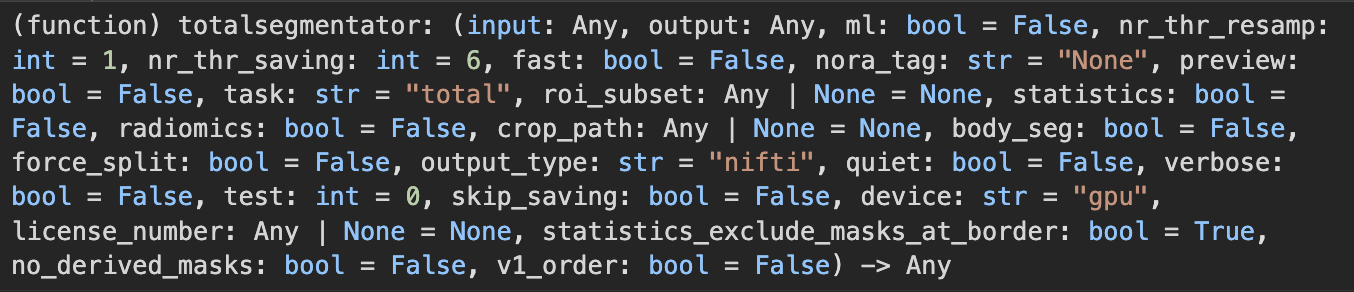

After totalsegmentator completes you should end up with a new folder in the sample_pt directory with separate `nifti` files containing the segmentation masks for each segmented structure:

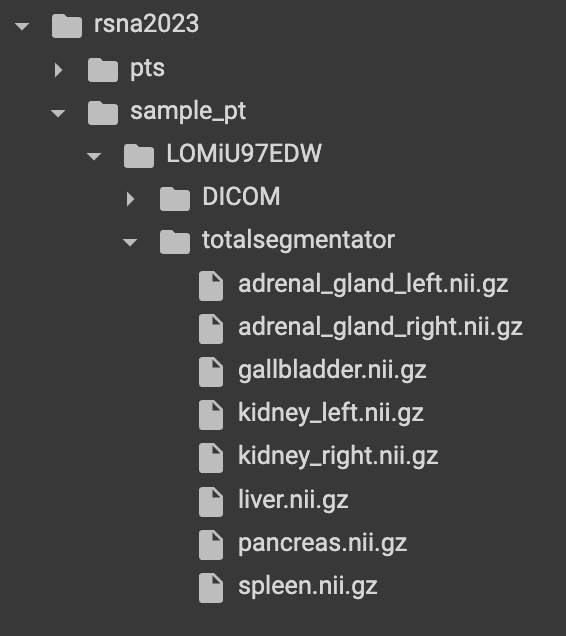

In [ ]:
# Let's explore the structure of a nifti file:
nifti_liver = nib.load(sample_pt/'totalsegmentator'/'liver.nii.gz')

# The nifti file header stores metadata analogous to the DICOM header:
print(nifti_liver.header)

In [ ]:
# The liver segmentation mask is an array of 110 512x512 bitmasks, one for each CT slice
print(nifti_liver.shape)

In [ ]:
# Each bitmask is a 512x512 pixel array where 1 = liver and 0 = not liver:
%matplotlib inline
im = 85
nifti_slice = nifti_liver.get_fdata()[:,:,im]
plt.imshow(nifti_slice, cmap='gray')
plt.show()

In [ ]:
## Notice that the nifti coordinate system differs from the conventional radiology coordinate system, so the image is rotated.
## We'll have to take this into account when we re-align these masks with their corresponding DICOM files.

# Essentially, we can rotate the image by 90 degrees counterclockwise to return it to its standard orientation:
rotated_liver = np.rot90(nifti_slice)
plt.imshow(rotated_liver, cmap='gray')
plt.show()

In [ ]:
# Let's make sure we can find the correponding DICOM file for this liver segment.
# First we'll sort the files in our DICOM directory using info from the DICOM header:
dcms = [dcmread(x) for x in (sample_pt/"DICOM/").iterdir() if x.suffix == ".dcm"]
dcms.sort(key=lambda x: x.InstanceNumber, reverse=True)

# Now that the DICOMs are sorted we can pick the one based on the index of the mask we choose earlier:
dcm = dcms[im]
# Let's adjust the window and level too so it looks nice:
img=get_windowed_image(dcm)

# Here we're defining a colormap for our segmentation mask. We'll make the liver mask dark red and the background pixels transparent:
overlay_colormap = ListedColormap(['none', 'darkred'])
overlay_colormap.set_under('none')  # Set the color for unmasked values to none

# Finally we'll plot our images - the mask, the corresponding DICOM image, and then the mask overlaid on the DICOM
fig, axs = plt.subplots(1,3, figsize=(15,5))

axs[0].imshow(rotated_liver, cmap='gray')
axs[0].set_title("Segmentation mask")

axs[1].imshow(img, cmap='gray')
axs[1].set_title("DICOM")

# And finally overlay the segmentation on the CT image:
axs[2].imshow(img, cmap='gray')
axs[2].imshow(rotated_liver, cmap=overlay_colormap, alpha=0.4)
axs[2].set_title("Overlay")

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()

plt.show()

### So far so good!! TotalSegmentator did a great job segmenting the liver on this slice, and we've shown that we can read the segmentation mask and line it up correctly with our DICOM files.

In [ ]:
# Let's rotate the rest of the liver segmentation so we don't have to deal with the `nifti` coordinates again:
liver_arr = np.rot90(nifti_liver.get_fdata())

# And let's check out the liver in 3d as a check on the rest of the segmented slices:
nonzero_indices = np.nonzero(liver_arr)
xs, ys, zs = nonzero_indices

fig = go.Figure(data=[go.Scatter3d(x=xs, y=ys, z=zs, mode='lines', marker=dict(size=1, color='rgba(1,0,0,0.005)'))])
fig.update_layout(scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'))
fig.show()

In [ ]:
# More unused var cleanup
try:
  del xs, ys, zs, rotated_liver, overlay_colormap, nonzero_indices, nifti_slice, nifti_liver, liver_arr, img, im, fig, axs, ax
except NameError:
  pass

## **Let's Recap**


1.   Totalsegmentator is **amazing** and should be the starting point for any CT segmentation task. With a GPU you'll get accurate segmentations of 117 structures in a few minutes.
2.   You can significantly decreased segmentation time by passing an `roi_subset` array to limit which structures are segmented.
3.   Totalsegmentator takes `DICOM` as input (yay!) but doesn't produce `DICOM SEG` output (boo!)
4.   The default `nifti` output is pretty easy to manipulate. It consists primarily of a bitmask array that matches the input array dimensions. So if you send in 100 `DICOM` files, each containing a 512x512 px CT image, you'll get back a (512,512,100) segmentation mask array.



# Quality Checks

In [ ]:
# Before moving on to the DICOM SEG conversion process, let's spend a little more time verifying some of our assumptions.

### 1. Are each of the nifti segmentations files the same shape as the original CT scan?
DICOM_dimensions = dcm.Rows, dcm.Columns, len(dcms)
segs = [x for x in (sample_pt/'totalsegmentator').iterdir()]
for seg in segs:
  assert(nib.load(seg).shape == DICOM_dimensions)
  print(f"DICOM dims == {seg.name} dims")

In [ ]:
### 2. Do all of the segmentation masks line up correctly with the CT scan?
num_images = len(dcms)
num_rows = (num_images + 5) // 6  # Calculate the number of rows needed with 6 columns

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, 6, figsize=(15,48))

# Flatten the 2D array of subplots into a 1D array for easier iteration
axes = axes.flatten()

loaded_segs = [ np.rot90(nib.load(seg).get_fdata()) for seg in segs ]

colors = ['Greens','Reds','Blues','autumn','PiYG','PiYG_r','Wistia','Purples','Accent','cubehelix']

# Iterate through the images and plot each one in a subplot
for i, dcm in enumerate(dcms):
    img = get_windowed_image(dcm)

    # Plot the image on the current subplot
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')  # Turn off axis labels for better visualization

    # Iterate through loaded segmentation masks and plot each one with a different color
    for j, seg_arr in enumerate(loaded_segs):
        if np.any(seg_arr[:, :, i]):
            alpha = np.where(seg_arr[:, :, i] > 0, 0.7, 0)
            # And finally overlay the segmentation on the CT image with transparency and a unique color
            axes[i].imshow(seg_arr[:, :, i], cmap=colors[j], alpha=alpha)

# If there are empty subplots, remove them
for i in range(num_images, num_rows * 6):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [ ]:
try:
  del seg_arr, seg, num_rows, num_images, loaded_segs, j, img, i, fig, colors, axes, alpha, DICOM_dimensions
except NameError:
  pass

# `nifti` to `DICOM SEG`

## Recap


1.   TotalSegmentator - 🔥, right?
2.   We can extract the bitmap segmentation masks and properly align them with the corresponding DICOM files.

  ▶  That's all we need to create DICOM SEG!  ◀



We essentially just need to move the segmentation masks from the `nifti` files they are currently in to `DICOM SEG` files.
`DICOM SEG` and `nifti` are quite similar - both contain headers that encode metadata that enable display systems to consistently display their content, and multidimensional arrays of data (in this case, pixel data or bitmaps)

We'll use the `highdicom` python library to help ensure we're building valid `DICOM SEG` objects.

In [ ]:
# The DICOM header of DICOM SEG files includes some metadata useful for tracking the segmentation workflow,
# such as the algorithm used, a description of each segmentation, and, importantly, direct references to the
# source DICOM files.
algorithm_identification = AlgorithmIdentificationSequence(
    name='DIDO_totalseg',
    version='RSNA 2023',
    family=codes.cid7162.ArtificialIntelligence
)

# Out segmentation masks have the same pixel dimensions as the corresponding DICOM files
series_num = dcms[0].SeriesNumber * 10
pixel_spacing = dcms[0].PixelSpacing
slice_thickness = dcms[0].SliceThickness
pixel_measures = PixelMeasuresSequence(
    pixel_spacing=pixel_spacing,
    slice_thickness=slice_thickness,
    spacing_between_slices=None
)
# We're going to create a single DICOM file that contains ALL of our segmentations - pretty neat.
## CAUTION - Getting the full benefit of DICOM SEG requires having accurate metadata for each segmented structure.
##   This facilitates the proper indexing and retrieval from a DICOM archive, a core strength of DICOM SEG over alternate formats like nifti.
##   The below code is a reasonable first-pass effort at using proper `segmented_property_category` and `segmented_property_type` codes
##   but a production-caliber system should include even more information, such as laterality, anatomic region, and other similar descriptors.
##   Consider using dcmqi or another more robustly supported tool to help.
segment_descriptions = []
masks = []
for idx,seg in enumerate(segs):
  seg_label = seg.stem[:-4]
  print(f"Segment #{idx+1} of {len(segs)}: {seg_label}")
  category_code, type_code = coded_concepts_from_totalseg_label(seg_label, totalseg_to_snomed_dict)
  seg_desc = SegmentDescription(
      segment_number=idx+1,
      segment_label=seg_label,
      segmented_property_category=codes.cid7150.AnatomicalStructure if category_code is None else category_code,
      segmented_property_type=codes.cid7166.Tissue if type_code is None else type_code,
      algorithm_type=SegmentAlgorithmTypeValues.AUTOMATIC,
      algorithm_identification=algorithm_identification,
      tracking_uid=generate_uid(),
      tracking_id='totalsegmentator_dicomseg'
  )
  seg_mask = nib.load(seg)
  masks.append(np.rot90(seg_mask.get_fdata()).transpose(2,0,1))
  segment_descriptions.append(seg_desc)
print("Creating DICOM SEG")
seg_dataset = Segmentation(
    source_images=dcms,
    pixel_array=np.stack(masks, axis=3),
    segmentation_type=SegmentationTypeValues.BINARY,
    segment_descriptions=segment_descriptions,
    series_instance_uid=generate_uid(),
    series_number=series_num,
    pixel_measures=pixel_measures,
    sop_instance_uid=generate_uid(),
    instance_number=1,
    manufacturer='RSNA 2023 DIDO Segmentation',
    manufacturer_model_name='DICOM SEG Segmentations from TotalSegmentator',
    software_versions='RSNA 2023',
    device_serial_number='90210'
)
print("Saving DICOM SEG")
new_dir = Path(sample_pt/'totalseg_dicomseg_single')
new_dir.mkdir(exist_ok=True)
fn = 'totalsegmentator_dicomsegs.dcm'
output_path = new_dir/fn
seg_dataset.SeriesDescription = 'TotalSegmentator'
# Here we're assigning colors to the segmented structures so they'll look nicer in the downstream display applications.
# We've borrowed these colors from `3D Slicer`
for seg_seq in seg_dataset.SegmentSequence:
  seg_label = seg_seq[0x0062,0x0005].value
  if seg_label in anatomy_colors:
    rgb = anatomy_colors[seg_label]
  else:
    rgb = anatomy_colors['tissue']
  seg_seq.add_new([0x0062,0x000d],'US',srgb_to_DICOMLab(rgb))
seg_dataset.save_as(output_path)


In [ ]:
# Delete the original nifti-format totalsegmentator output, leaving the DICOM SEG
shutil.rmtree(sample_pt/'totalsegmentator')

# Zip the sample patient dir including the source DICOM and the DICOM SEG file
!zip -r /content/totalseg_dicomseg_single.zip /content/rsna2023/sample_pt

That's it! You should now have a new dir in your sample_pt directory called `TotalSegmentator` that contains a single `DICOM SEG` file containing all of our segmentations!

You can now download that single `DICOM SEG` file and open it up in `3D Slicer`, send it to a PACS receiver, or load it in the OHIF Viewer. You'll also need the source `DICOM` files - although the `DICOM SEG` file references the corresponding CT, it doesn't actually copy the CT pixel data.

You should see a zip file in the project root directory in Colab - this contains the DICOM SEG file and the corresponding CT scan - you can import this zip file directly into `3D Slicer` and see the results.

We limited ourselves to 8 structures in this tutorial. Here's a glimpse of what TotalSegmentator does with a full Abdomen/Pel CT scan:



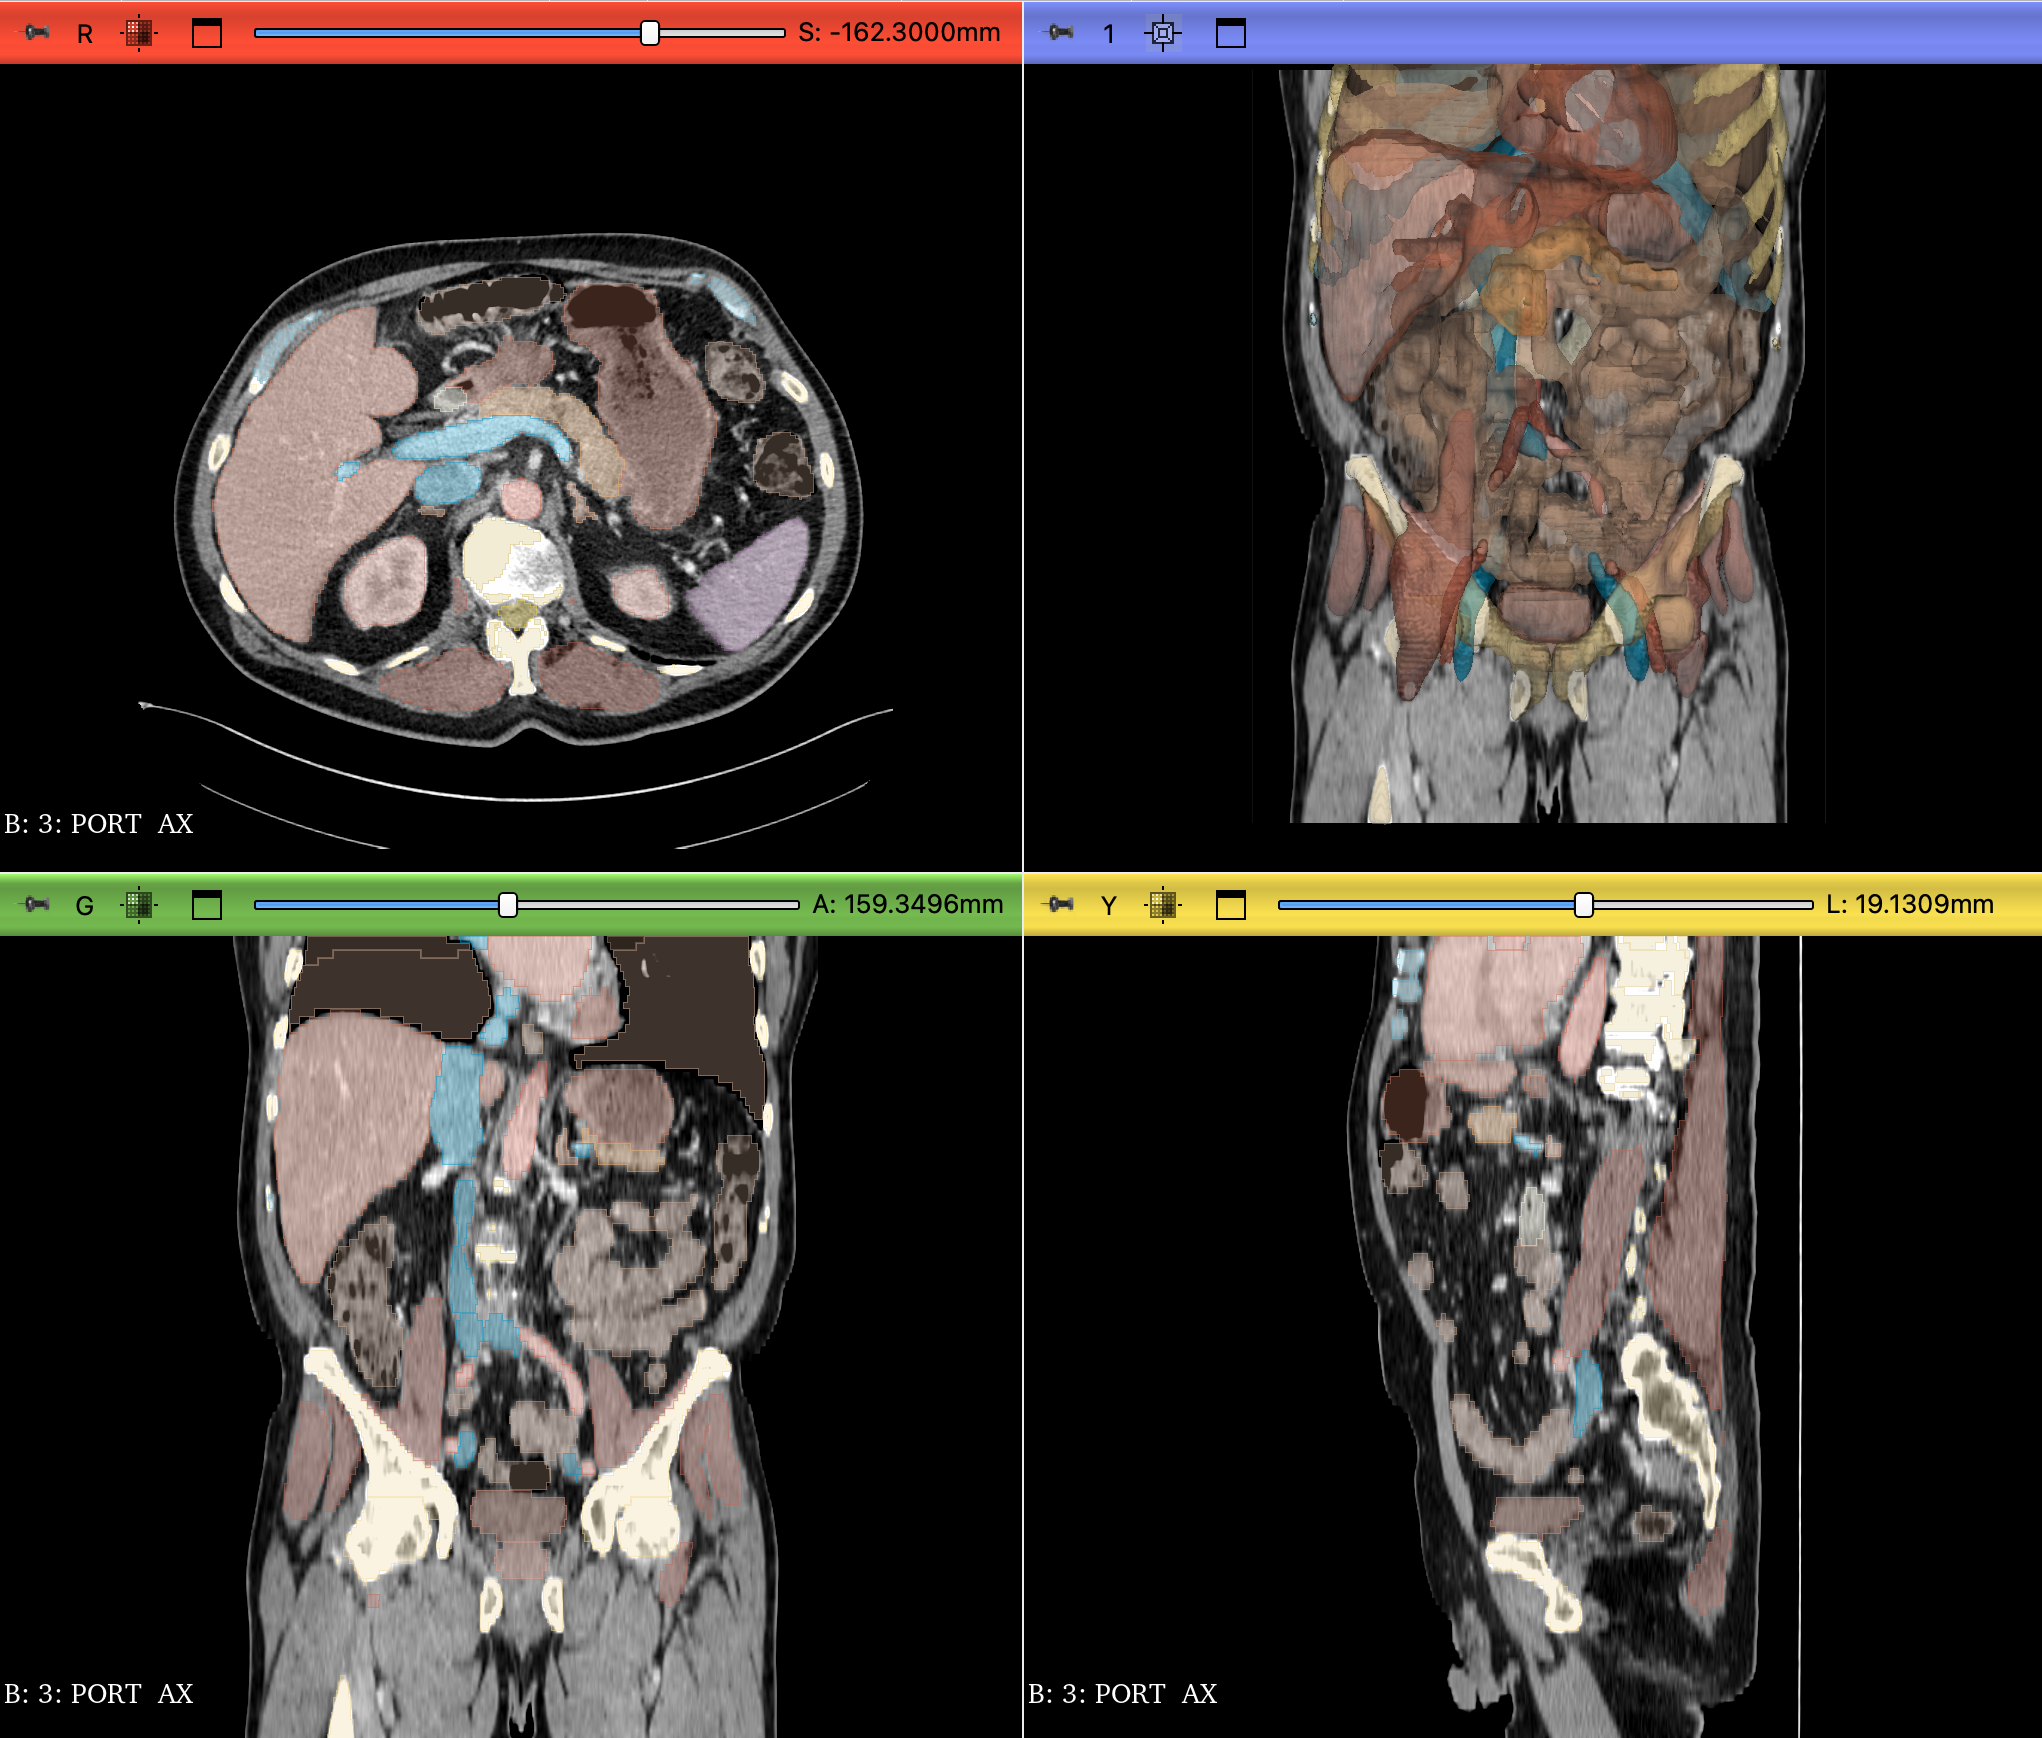

TotalSegmentator is available as a plugin in `3D Slicer`, on the [MHub.ai platform](https://mhub.ai/models/totalsegmentator), and as an installable python library (`pip install totalsegmentator`) which can easily be used on Google Colab.